This notebook is designed to run in a IBM Watson Studio default runtime (NOT the Watson Studio Apache Spark Runtime as the default runtime with 1 vCPU is free of charge). Therefore, we install Apache Spark in local mode for test purposes only. Please don't use it in production.

In case you are facing issues, please read the following two documents first:

https://github.com/IBM/skillsnetwork/wiki/Environment-Setup

https://github.com/IBM/skillsnetwork/wiki/FAQ

Then, please feel free to ask:

https://coursera.org/learn/machine-learning-big-data-apache-spark/discussions/all

Please make sure to follow the guidelines before asking a question:

https://github.com/IBM/skillsnetwork/wiki/FAQ#im-feeling-lost-and-confused-please-help-me


If running outside Watson Studio, this should work as well. In case you are running in an Apache Spark context outside Watson Studio, please remove the Apache Spark setup in the first notebook cells.

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')


In [2]:
!pip install pyspark==2.4.5

In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

Welcome to exercise one of week two of “Apache Spark for Scalable Machine Learning on BigData”. In this exercise you’ll read a DataFrame in order to perform a simple statistical analysis. Then you’ll rebalance the dataset. No worries, we’ll explain everything to you, let’s get started.

Let’s create a data frame from a remote file by downloading it:




In [5]:
# delete files from previous runs
!rm -f hmp.parquet*

# download the file containing the data in PARQUET format
!wget https://github.com/IBM/coursera/raw/master/hmp.parquet
    
# create a dataframe out of it
df = spark.read.parquet('hmp.parquet')

# register a corresponding query table
df.createOrReplaceTempView('df')

--2020-07-31 07:47:49--  https://github.com/IBM/coursera/raw/master/hmp.parquet
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet [following]
--2020-07-31 07:47:49--  https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet [following]
--2020-07-31 07:47:49--  https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932997 (911K) [application/octet-stream]
Saving 

Let’s have a look at the data set first. This dataset contains sensor recordings from different movement activities as we will see in the next week’s lectures. X, Y and Z contain accelerometer sensor values whereas the class field contains information about which movement has been recorded. The source field is optional and can be used for data lineage since it contains the file name of the original file where the particular row was imported from.

More details on the data set can be found here:
https://github.com/wchill/HMP_Dataset


In [6]:
df.show()
df.printSchema()

+---+---+---+--------------------+-----------+
|  x|  y|  z|              source|      class|
+---+---+---+--------------------+-----------+
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 21| 52| 34|Accelerometer-201...|Brush_teeth|
| 22| 51| 34|Accelerometer-201...|Brush_teeth|
| 20| 50| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 34|Accelerometer-201...|Brush_teeth|
| 22| 50| 34|Accelerometer-201...|Brush_teeth|
| 22| 51| 35|Accelerometer-201...|Brush_teeth|
| 21| 51| 33|Accelerometer-201...|Brush_teeth|
| 20| 50| 34|Accelerometer-201...|Brush_teeth|
| 21| 49| 33|Accelerometer-201...|Brush_teeth|
| 21| 49| 33|Accelerometer-201...|Brush_teeth|
| 20| 51| 35|Accelerometer-201...|Brush_teeth|
| 18| 49| 34|Accelerometer-201...|Brush_teeth|
| 19| 48| 34|Accelerometer-201...|Brush_teeth|
| 16| 53| 34|Accelerometer-201...|Brush_teeth|
| 18| 52| 35|

This is a classical classification data set. One thing we always do during data analysis is checking if the classes are balanced. In other words, if there are more or less the same number of example in each class. Let’s find out by a simple aggregation using SQL.

In [7]:
spark.sql('select class,count(*) from df group by class').show()

+--------------+--------+
|         class|count(1)|
+--------------+--------+
| Use_telephone|   15225|
| Standup_chair|   25417|
|      Eat_meat|   31236|
|     Getup_bed|   45801|
|   Drink_glass|   42792|
|    Pour_water|   41673|
|     Comb_hair|   23504|
|          Walk|   92254|
|  Climb_stairs|   40258|
| Sitdown_chair|   25036|
|   Liedown_bed|   11446|
|Descend_stairs|   15375|
|   Brush_teeth|   29829|
|      Eat_soup|    6683|
+--------------+--------+



As you can see there is quite an imbalance between classes. Before we dig into this, let’s re-write the same query using the DataFrame API – just in case you are not familiar with SQL. As we’ve learned before, it doesn’t matter if you express your queries with SQL or the DataFrame API – it all gets boiled down into the same execution plan optimized by Tungsten and accelerated by Catalyst. You can even mix and match SQL and DataFrame API code if you like.

Again, more details on the API can be found here:
https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame


In [8]:
df.groupBy('class').count().show()

+--------------+-----+
|         class|count|
+--------------+-----+
| Use_telephone|15225|
| Standup_chair|25417|
|      Eat_meat|31236|
|     Getup_bed|45801|
|   Drink_glass|42792|
|    Pour_water|41673|
|     Comb_hair|23504|
|          Walk|92254|
|  Climb_stairs|40258|
| Sitdown_chair|25036|
|   Liedown_bed|11446|
|Descend_stairs|15375|
|   Brush_teeth|29829|
|      Eat_soup| 6683|
+--------------+-----+



Let’s create a bar plot from this data. We’re using the pixidust library, which is Open Source, because of its simplicity. But any other library like matplotlib is fine as well. 


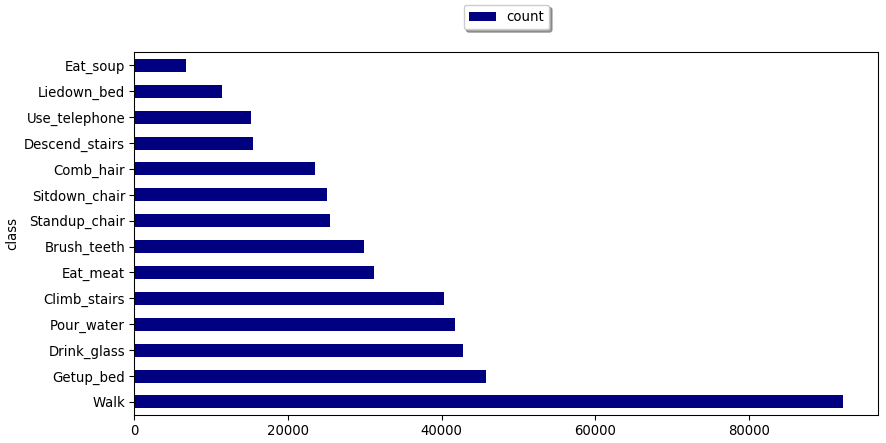

In [9]:
import pixiedust
from pyspark.sql.functions import col
counts = df.groupBy('class').count().orderBy('count')
pixiedust.display(counts)

This looks nice, but it would be nice if we can aggregate further to obtain some quantitative metrics on the imbalance like, min, max, mean and standard deviation. If we divide max by min we get a measure called minmax ration which tells us something about the relationship between the smallest and largest class. Again, let’s first use SQL for those of you familiar with SQL. Don’t be scared, we’re used nested sub-selects, basically selecting from a result of a SQL query like it was a table. All within on SQL statement.

In [10]:
spark.sql('''
    select 
        *,
        max/min as minmaxratio -- compute minmaxratio based on previously computed values
        from (
            select 
                min(ct) as min, -- compute minimum value of all classes
                max(ct) as max, -- compute maximum value of all classes
                mean(ct) as mean, -- compute mean between all classes
                stddev(ct) as stddev -- compute standard deviation between all classes
                from (
                    select
                        count(*) as ct -- count the number of rows per class and rename it to ct
                        from df -- access the temporary query table called df backed by DataFrame df
                        group by class -- aggrecate over class
                )
        )   
''').show()

+----+-----+------------------+------------------+-----------------+
| min|  max|              mean|            stddev|      minmaxratio|
+----+-----+------------------+------------------+-----------------+
|6683|92254|31894.928571428572|21284.893716741157|13.80427951518779|
+----+-----+------------------+------------------+-----------------+



The same query can be expressed using the DataFrame API. Again, don’t be scared. It’s just a sequential expression of transformation steps. You now an choose which syntax you like better.

In [11]:
from pyspark.sql.functions import col, min, max, mean, stddev

df \
    .groupBy('class') \
    .count() \
    .select([ 
        min(col("count")).alias('min'), 
        max(col("count")).alias('max'), 
        mean(col("count")).alias('mean'), 
        stddev(col("count")).alias('stddev') 
    ]) \
    .select([
        col('*'),
        (col("max") / col("min")).alias('minmaxratio')
    ]) \
    .show()


+----+-----+------------------+------------------+-----------------+
| min|  max|              mean|            stddev|      minmaxratio|
+----+-----+------------------+------------------+-----------------+
|6683|92254|31894.928571428572|21284.893716741157|13.80427951518779|
+----+-----+------------------+------------------+-----------------+



Now it’s time for you to work on the data set. First, please create a table of all classes with the respective counts, but this time, please order the table by the count number, ascending.

In [12]:
df.groupBy('class').count().sort('count', ascending=True).show()

+--------------+-----+
|         class|count|
+--------------+-----+
|      Eat_soup| 6683|
|   Liedown_bed|11446|
| Use_telephone|15225|
|Descend_stairs|15375|
|     Comb_hair|23504|
| Sitdown_chair|25036|
| Standup_chair|25417|
|   Brush_teeth|29829|
|      Eat_meat|31236|
|  Climb_stairs|40258|
|    Pour_water|41673|
|   Drink_glass|42792|
|     Getup_bed|45801|
|          Walk|92254|
+--------------+-----+



Pixiedust is a very sophisticated library. It takes care of sorting as well. Please modify the bar chart so that it gets sorted by the number of elements per class, ascending. Hint: It’s an option available in the UI once rendered using the display() function.


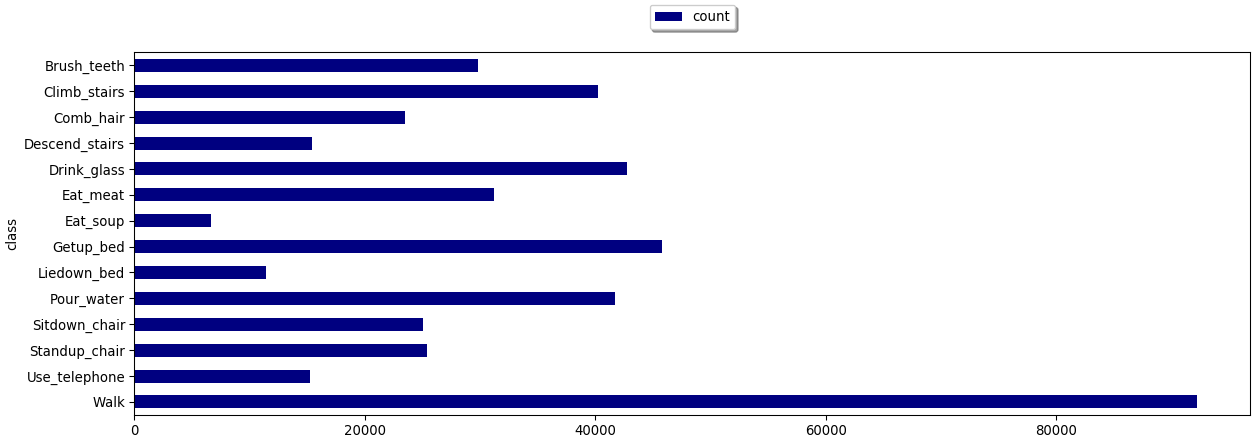

In [14]:
import pixiedust
from pyspark.sql.functions import col
counts = df.groupBy('class').count().sort('count', ascending=True)
pixiedust.display(counts)

Imbalanced classes can cause pain in machine learning. Therefore let’s rebalance. In the flowing we limit the number of elements per class to the amount of the least represented class. This is called undersampling. Other ways of rebalancing can be found here:

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [15]:
from pyspark.sql.functions import min

# create a lot of distinct classes from the dataset
classes = [row[0] for row in df.select('class').distinct().collect()]

# compute the number of elements of the smallest class in order to limit the number of samples per calss
min = df.groupBy('class').count().select(min('count')).first()[0]

# define the result dataframe variable
df_balanced = None

# iterate over distinct classes
for cls in classes:
    
    # only select examples for the specific class within this iteration
    # shuffle the order of the elements (by setting fraction to 1.0 sample works like shuffle)
    # return only the first n samples
    df_temp = df \
        .filter("class = '"+cls+"'") \
        .sample(False, 1.0) \
        .limit(min)
    
    # on first iteration, assing df_temp to empty df_balanced
    if df_balanced == None:    
        df_balanced = df_temp
    # afterwards, append vertically
    else:
        df_balanced=df_balanced.union(df_temp)

Please verify, by using the code cell below, if df_balanced has the same number of elements per class. You should get 6683 elements per class.

In [16]:
df_balanced.groupBy('class').count().show()

+--------------+-----+
|         class|count|
+--------------+-----+
| Use_telephone| 6683|
| Standup_chair| 6683|
|      Eat_meat| 6683|
|     Getup_bed| 6683|
|   Drink_glass| 6683|
|    Pour_water| 6683|
|     Comb_hair| 6683|
|          Walk| 6683|
|  Climb_stairs| 6683|
| Sitdown_chair| 6683|
|   Liedown_bed| 6683|
|Descend_stairs| 6683|
|   Brush_teeth| 6683|
|      Eat_soup| 6683|
+--------------+-----+

